In [1]:
import numpy as np

def equity_and_savings(sale_price, down_payment, initial_rent, equity_appreciation_rate,
                       mortgage_years=30.0, mortgage_interest_rate=0.04, property_tax_rate=0.0125,
                       annual_maintenance=1000.0, annual_hoa=2000.0, annual_home_insurance=1500.0,
                       marginal_income_tax_rate=0.30, inflation_rate=0.02, savings_interest_rate=0.04,
                       closing_costs=0.05, selling_costs=0.05, number_of_months=300, debug=True):
    """
    Purpose:
    Compare equity build-up in two scenarios
    (1) Buy house with monthly mortgage payment and pay monthly fees
        (e.g., HOA, insurance, maintenance)
    (2) Pay rent every month and invest the difference in a savings (or retirement) account

    This function will calculate the net equity after sale (buy scenario) and the equity build-up
    of both scenarios for <no_months> months and return all as numpy arrays

    Inputs:
    - purchase_price (US$): Purchase price of the house (buy scenario)
    - down_payment (US$): Down payment of the house (buy scenario)
    - initial_rent (US$): Initial monthly rent (rent scenario)
    - equity_appreciation_rate (1): Annual appreciation of real estate (buy and rent scenarios)
    - mortgage_years (years): Mortgage length (e.g., 30 years) (buy scenario)
    - mortgage_interest_rate (1): Interest rate for mortgage (buy scenario)
    - property_tax_rate (1): Annual rate of property tax (buy scenario)
    - annual_maintenance (US$): Annual maintenance fees (buy scenario)
    - annual_hoa (US$): Annual payments to home owners association (buy scenario)
    - annual_home_insurance (US$): Annual insurance payments (buy scenario)
    - marginal_income_tax_rate (1): Depends on the tax bracket (buy scenario)
    - inflation_rate (1): Inflation rate used to estimate increases in annual fees (buy scenario)
    - savings_interest_rate (1): Estimated interest rate for the difference between buy and rent (rent scenario)
    - closing_costs (1): Percentage of home price that is paid when closing purchase financing (buy scenario)
    - selling_costs (1): Percentage of home price that is paid when closing sale (buy scenario)
    - number_of_months (months): Number of months to plot (buy and rent scenario)
    - debug (Boolean): Whether to print debug information
    """

    monthly_mortgage_payment = (purchase_price-down_payment) * (1.0-1.0/(1.0+mortgage_interest_rate/12.0)) \
        / ((1.0/(1.0+mortgage_interest_rate/12.0)) - (1.0/(1.0+mortgage_interest_rate/12.0)**(mortgage_years*12.0+1.0)))
    if debug:
        print('The monthly mortgage is {:.2f}'.format(monthly_mortgage_payment))
    
    # Initialize arrays
    home_value = np.zeros(number_of_months) # Current value of the house
    debt = np.zeros(number_of_months) # Current debt in mortgage account
    equity = np.zeros(number_of_months) # Current equity owned
    net_equity = np.zeros(number_of_months) # Current asset value after sale
    cash_outflow = np.zeros(number_of_months) # Total outflow of cash at the current month (buy scenario)
    rent = np.zeros(number_of_months) # Current value of rent
    savings = np.zeros(number_of_months) # Savings built up over time when renting

    # Assume that in both scenarios, we start with the money paid as down payment + closing costs
    home_value[0] = purchase_price    
    debt[0] = purchase_price-down_payment    
    equity[0] = down_payment # closing costs don't add to equity
    net_equity[0] = purchase_price * (1 - selling_costs)
    cash_outflow[0] = down_payment + closing_costs*(purchase_price-down_payment) # considering closing_costs
    rent[0] = initial_rent    
    savings[0] = cash_outflow[0] - rent[0]  # consider closing_costs and correct cash flow
    if debug:
        print('In month 0, the cash outflow was {:.2f}, and the rent was {:.2f}'.format(
            cash_outflow[0], rent[0]))

    for mo in range(1,number_of_months):
        ## Buy scenario
        home_value[mo] = home_value[mo-1]*(1.0+equity_appreciation_rate/12)
        # Contribution to principal
        interest_on_debt = debt[mo-1]*mortgage_interest_rate/12
        paid_principal = monthly_mortgage_payment-interest_on_debt
        
        # Total cash outflow
        insurance_payment = annual_home_insurance/12*(1.0+inflation_rate/12)**(mo-1)
        hoa_payment = annual_hoa/12*(1.0+inflation_rate/12)**(mo-1)
        maintenance_payment = annual_maintenance/12*(1.0+inflation_rate/12)**(mo-1)
        property_tax_payment = home_value[mo-1]*property_tax_rate/12
        savings_interest_deduction = (interest_on_debt+property_tax_payment)*marginal_income_tax_rate
        cash_outflow[mo] = (monthly_mortgage_payment+insurance_payment+hoa_payment+
            maintenance_payment+property_tax_payment-savings_interest_deduction)
        # Update debt and equity
        debt[mo] = debt[mo-1]-paid_principal
        equity[mo] = home_value[mo]-debt[mo]
        net_equity[mo] = equity[mo] - selling_costs * home_value[mo]
        if debug:
            print('In month {}, home value is {:.2f}, debt is {:.2f}, and equity is {:.2f}'.format(
                mo, home_value[mo], debt[mo], equity[mo]))

        ## Rent scenario
        rent[mo] = (1.0+equity_appreciation_rate/12)*rent[mo-1]
        savings[mo] = (savings[mo-1]*(1.0+savings_interest_rate/12)+
            cash_outflow[mo]-rent[mo])
        if debug:
            print('In month {}, current savings are {:.2f}'.format(mo, savings[mo]))
    
    return (equity, savings, monthly_mortgage_payment, cash_outflow, rent, net_equity)

In [2]:
def approximate_monthly_payments(sale_price, down_payment, initial_rent, equity_appreciation_rate,
                       mortgage_years=30.0, mortgage_interest_rate=0.04, property_tax_rate=0.0125,
                       annual_maintenance=1000.0, annual_hoa=2000.0, annual_home_insurance=1500.0,
                       marginal_income_tax_rate=0.30, inflation_rate=0.02, savings_interest_rate=0.04,
                       closing_costs=0.05, selling_costs=0.05, number_of_months=300, debug=False):
    """
    Purpose:
    Compare equity build-up in two scenarios
    (1) Buy house with monthly mortgage payment and pay monthly fees
        (e.g., HOA, insurance, maintenance)
    (2) Pay rent every month and invest the difference in a savings (or retirement) account

    This function will calculate the average monthly outflow in the buy scenario (averaged up to the current month) and
    the current month's rent (rent scenario), returning them as numpy arrays

    Inputs:
    - purchase_price (US$): Purchase price of the house (buy scenario)
    - down_payment (US$): Down payment of the house (buy scenario)
    - initial_rent (US$): Initial monthly rent (rent scenario)
    - equity_appreciation_rate (1): Annual appreciation of real estate (buy and rent scenarios)
    - mortgage_years (years): Mortgage length (e.g., 30 years) (buy scenario)
    - mortgage_interest_rate (1): Interest rate for mortgage (buy scenario)
    - property_tax_rate (1): Annual rate of property tax (buy scenario)
    - annual_maintenance (US$): Annual maintenance fees (buy scenario)
    - annual_hoa (US$): Annual payments to home owners association (buy scenario)
    - annual_home_insurance (US$): Annual insurance payments (buy scenario)
    - marginal_income_tax_rate (1): Depends on the tax bracket (buy scenario)
    - inflation_rate (1): Inflation rate used to estimate increases in annual fees (buy scenario)
    - savings_interest_rate (1): Estimated interest rate for the difference between buy and rent (rent scenario)
    - closing_costs (1): Percentage of home price that is paid when closing purchase financing (buy scenario)
    - selling_costs (1): Percentage of home price that is paid when closing sale (buy scenario)
    - number_of_months (months): Number of months to plot (buy and rent scenario)
    - debug (Boolean): Whether to print debug information
    """
    (equity, savings, monthly_mortgage_payment, cash_outflow, rent, net_equity) = equity_and_savings(
        sale_price, down_payment, initial_rent, equity_appreciation_rate, mortgage_years,
        mortgage_interest_rate, property_tax_rate, annual_maintenance, annual_hoa,
        annual_home_insurance, marginal_income_tax_rate, inflation_rate, savings_interest_rate,
        closing_costs, selling_costs, number_of_months, debug)
    
    monthly_buy = np.zeros(number_of_months)
    monthly_rent = np.zeros(number_of_months)
    
    for mo in range(1,number_of_months):
        monthly_buy[mo] = cash_outflow[:(mo+1)].sum()/mo
        monthly_rent[mo] = rent[mo]
    
    return (monthly_buy, monthly_rent)

In [3]:
def find_payback_time(sale_price, down_payment, initial_rent, equity_appreciation_rate, number_of_months, 
                       mortgage_years=30.0, mortgage_interest_rate=0.04, property_tax_rate=0.0125,
                       annual_maintenance=1000.0, annual_hoa=2000.0, annual_home_insurance=1500.0,
                       marginal_income_tax_rate=0.30, inflation_rate=0.02, savings_interest_rate=0.04,
                       closing_costs=0.05, selling_costs=0.05, debug=False):
    """
    Purpose:
    Compare equity build-up in two scenarios
    (1) Buy house with monthly mortgage payment and pay monthly fees
        (e.g., HOA, insurance, maintenance)
    (2) Pay rent every month and invest the difference in a savings (or retirement) account

    This function will calculate the equity build-up of both scenarios for <no_months> months
    and return the number of months it will take for the buy scenario to be favorable, 
    or -1 if longer than <no_months> months

    Inputs:
    - purchase_price (US$): Purchase price of the house (buy scenario)
    - down_payment (US$): Down payment of the house (buy scenario)
    - initial_rent (US$): Initial monthly rent (rent scenario)
    - equity_appreciation_rate (1): Annual appreciation of real estate (buy and rent scenarios)
    - mortgage_years (years): Mortgage length (e.g., 30 years) (buy scenario)
    - mortgage_interest_rate (1): Interest rate for mortgage (buy scenario)
    - property_tax_rate (1): Annual rate of property tax (buy scenario)
    - annual_maintenance (US$): Annual maintenance fees (buy scenario)
    - annual_hoa (US$): Annual payments to home owners association (buy scenario)
    - annual_home_insurance (US$): Annual insurance payments (buy scenario)
    - marginal_income_tax_rate (1): Depends on the tax bracket (buy scenario)
    - inflation_rate (1): Inflation rate used to estimate increases in annual fees (buy scenario)
    - savings_interest_rate (1): Estimated interest rate for the difference between buy and rent (rent scenario)
    - closing_costs (1): Percentage of home price that is paid when closing purchase financing (buy scenario)
    - selling_costs (1): Percentage of home price that is paid when closing sale (buy scenario)
    - number_of_months (months): Number of months to plot (buy and rent scenario)
    - debug (Boolean): Whether to print debug information
    """
    (equity, savings, monthly_mortgage_payment, cash_outflow, rent, net_equity) = \
        equity_and_savings(sale_price, down_payment, initial_rent, equity_appreciation_rate, mortgage_years,
        mortgage_interest_rate, property_tax_rate, annual_maintenance, annual_hoa,
        annual_home_insurance, marginal_income_tax_rate, inflation_rate, savings_interest_rate,
        closing_costs, selling_costs, number_of_months, debug)

    estimated_difference = net_equity - savings # changed from equity to net_equity 
    payback = -1
    for ix in range(1, len(estimated_difference)):
        if estimated_difference[ix] >= 0.0:
            payback = ix
            break
    
    return (payback, number_of_months)

In [4]:
purchase_price = 420000.0
down_payment = 20000.0
equity_appreciation_rate = 0.02 # 3.0% -- Assumed the same for buy and rent scenarios
initial_rent = 1600.0 # Monthly payment

equity, savings, mortgage, cash_outflow, rent, net_equity = equity_and_savings(purchase_price, down_payment, initial_rent,
                                                                         equity_appreciation_rate)

The monthly mortgage is 1909.66
In month 0, the cash outflow was 40000.00, and the rent was 1600.00
In month 1, home value is 420700.00, debt is 399423.67, and equity is 21276.33
In month 1, current savings are 39116.24
In month 2, home value is 421401.17, debt is 398845.42, and equity is 22555.74
In month 2, current savings are 39833.92
In month 3, home value is 422103.50, debt is 398265.25, and equity is 23838.26
In month 3, current savings are 40553.02
In month 4, home value is 422807.01, debt is 397683.14, and equity is 25123.87
In month 4, current savings are 41273.56
In month 5, home value is 423511.69, debt is 397099.09, and equity is 26412.60
In month 5, current savings are 41995.55
In month 6, home value is 424217.54, debt is 396513.09, and equity is 27704.45
In month 6, current savings are 42718.97
In month 7, home value is 424924.57, debt is 395925.14, and equity is 28999.43
In month 7, current savings are 43443.85
In month 8, home value is 425632.78, debt is 395335.23, and 

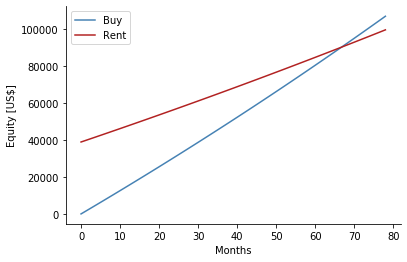

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

months = 80

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(net_equity[1:months], color='steelblue', label='Buy')
ax.plot(savings[1:months], color='firebrick', label='Rent')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Months')
ax.set_ylabel('Equity [US$]')
ax.legend()

plt.show()

In [6]:
purchase_price = 420000.0
down_payment = 20000.0
equity_appreciation_rate = 0.02 # 3.0% -- Assumed the same for buy and rent scenarios
initial_rent = 1600.0 # Monthly payment

monthly_buy, monthly_rent = approximate_monthly_payments(purchase_price, down_payment, initial_rent,
                                                                         equity_appreciation_rate)

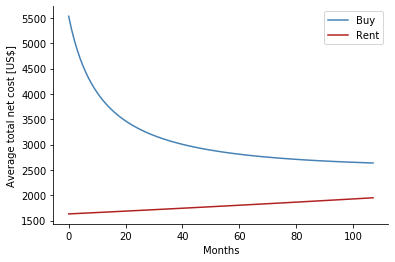

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

months = range(12,120)

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(monthly_buy[months], color='steelblue', label='Buy')
ax.plot(monthly_rent[months], color='firebrick', label='Rent')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Months')
ax.set_ylabel('Average total net cost [US$]')
ax.legend()

plt.show()

In [8]:
purchase_price = 420000.0
down_payment = 20000.0
equity_appreciation_rate = 0.02 # 3.0% -- Assumed the same for buy and rent scenarios
initial_rent = 1600.0 # Monthly payment

(payback, number_of_months) = find_payback_time(purchase_price, down_payment, initial_rent, equity_appreciation_rate, 120)

if (payback < 0):
    print('It will take more than {} months to payback the investment'.format(number_of_months))
else:
    print('It takes {} months to payback the investment'.format(payback))

It takes 68 months to payback the investment
